In [1]:
import os
import numpy as np
import pandas as pd
 
import sklearn.preprocessing
import sklearn.pipeline
import sklearn.linear_model

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from load_train_data import overview_data
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [3]:
x_train_df = pd.read_csv('x_train.csv')
y_train_df = pd.read_csv('y_train.csv')

overview_data(x_train_df, y_train_df)

x_train_df['total_text'] = x_train_df['website_name'] + ' ' + x_train_df['text']
x_train_df_text = x_train_df['website_name'] + ' ' + x_train_df['text']
x_train_df_text.head()

Shape of x_train_df: (2400, 2)
Shape of y_train_df: (2400, 1)

Print three instance from the training set in lists:
Input (website, review):
[['amazon', 'Oh and I forgot to also mention the weird color effect it has on your phone.'], ['amazon', "THAT one didn't work either."], ['amazon', 'Waste of 13 bucks.']]
Label:
[0, 0, 0]


More data from training set:
row     0 | y = 0 | Oh and I forgot to also mention the weird color effect it has on your phone.
row     1 | y = 0 | THAT one didn't work either.
row     2 | y = 0 | Waste of 13 bucks.
row     3 | y = 0 | Product is useless, since it does not have enough charging current to charge the 2 cellphones I was planning to use it with.
row     4 | y = 0 | None of the three sizes they sent with the headset would stay in my ears.
...
row  2395 | y = 1 | The sweet potato fries were very nice and seasoned well.
row  2396 | y = 1 | I could eat their bruschetta all day it is devine.
row  2397 | y = 1 | Ambience is perfect.
row  2398 | y = 1 | We 

0    amazon Oh and I forgot to also mention the wei...
1                  amazon THAT one didn't work either.
2                            amazon Waste of 13 bucks.
3    amazon Product is useless, since it does not h...
4    amazon None of the three sizes they sent with ...
dtype: object

In [4]:
X_train = x_train_df_text
y_train = y_train_df['is_positive_sentiment']

In [7]:
#vectorizer 1 --> lowercase + stop words
vectorizer_1 = CountVectorizer(lowercase=True, stop_words='english')
vectorizer_1.fit(X_train)
X_train_vector_1 = vectorizer_1.transform(X_train)
vocabulary_size_1 = len(vectorizer_1.vocabulary_)  # retrieve vocabulary and measure its size
print(vocabulary_size_1)

#vectorizer 2 --> lowercase + stop words + words that appear less than 2 times are eliminated
vectorizer_2 = CountVectorizer(lowercase=True, stop_words='english', min_df=2)
vectorizer_2.fit(X_train)
X_train_vector_2 = vectorizer_2.transform(X_train)
vocabulary_size_2 = len(vectorizer_2.vocabulary_)  # retrieve vocabulary and measure its size
print(vocabulary_size_2)

#vectorizer 3 --> lowercase + stop words + words that appear less than 3 times are eliminated
vectorizer_3 = CountVectorizer(lowercase=True, stop_words='english', min_df=3)
vectorizer_3.fit(X_train)
X_train_vector_3 = vectorizer_3.transform(X_train)
vocabulary_size_3 = len(vectorizer_3.vocabulary_)  # retrieve vocabulary and measure its size
print(vocabulary_size_3)

4256
1687
1005


In [8]:
simple_logistic = Pipeline([
    ('count', CountVectorizer(lowercase=True, stop_words='english')),
    ('log_reg', LogisticRegression(max_iter = 1200))
])

In [9]:
# range of hyperparameters
hyperparams_C = [0.001, 0.01, 0.1, 1, 10, 100, 200]
hyperparams_min_df = [1, 2, 3]

# create parameter grid
param_grid_log_reg = {
    'log_reg__C': list(hyperparams_C),  
    'count__min_df': hyperparams_min_df,
}
print('Created the grid!')  
print(hyperparams_C)

Created the grid!
[0.001, 0.01, 0.1, 1, 10, 100, 200]


In [10]:
from sklearn.metrics import roc_auc_score, make_scorer

scoring = make_scorer(roc_auc_score, greater_is_better=True)

grid_log_reg_5 = GridSearchCV(simple_logistic, param_grid_log_reg, scoring=scoring, cv=5, return_train_score=True)
grid_search_log_reg = grid_log_reg_5.fit(X_train, y_train)
print('Done grid search for CV 5!')

Done grid search for CV 5!


In [11]:
best_params = grid_log_reg_5.best_params_
print(best_params)
print("Best ROC AUC score found:", grid_log_reg_5.best_score_)

{'count__min_df': 1, 'log_reg__C': 1}
Best ROC AUC score found: 0.7975


In [12]:
cv_results = grid_search_log_reg.cv_results_

# Extract hyperparameters and scores
params = cv_results['params']
mean_test_scores = cv_results['mean_test_score']
mean_train_scores = cv_results['mean_train_score']
std_test_scores = cv_results['std_test_score']
std_train_scores = cv_results['std_train_score']
split0_test_scores = cv_results['split0_test_score']
split1_test_scores = cv_results['split1_test_score']
split2_test_scores = cv_results['split2_test_score']
split3_test_scores = cv_results['split3_test_score']
split4_test_scores = cv_results['split4_test_score']

split0_train_scores = cv_results['split0_train_score']
split1_train_scores = cv_results['split1_train_score']
split2_train_scores = cv_results['split2_train_score']
split3_train_scores = cv_results['split3_train_score']
split4_train_scores = cv_results['split4_train_score']
print(mean_test_scores)
print(cv_results.keys())

[0.68791667 0.70916667 0.76875    0.7975     0.78166667 0.76416667
 0.75541667 0.68666667 0.705      0.76583333 0.78625    0.7625
 0.74541667 0.74041667 0.68708333 0.70708333 0.76166667 0.77208333
 0.74541667 0.71791667 0.71125   ]
dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_count__min_df', 'param_log_reg__C', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])


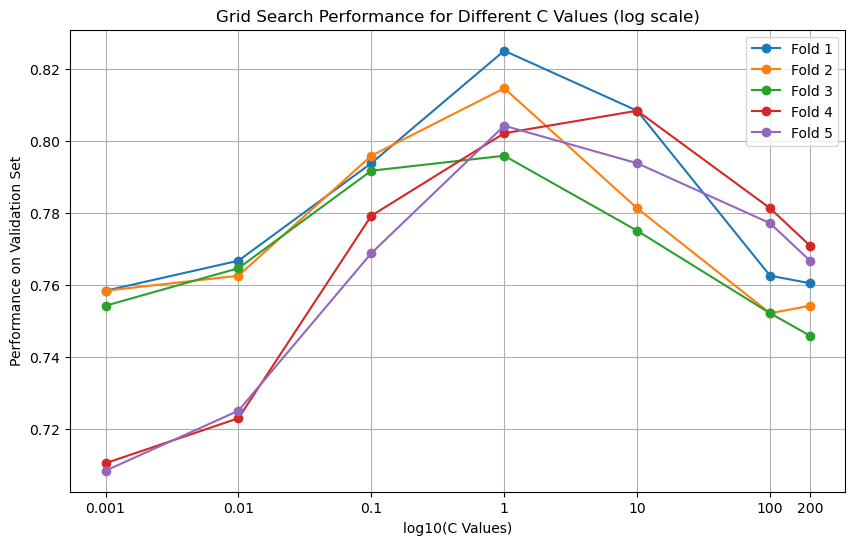

In [13]:
# Aggregate scores for each fold
aggregated_scores = {}
for i, scores in enumerate([split0_test_scores, split1_test_scores, split2_test_scores, split3_test_scores, split4_test_scores]):
    for j, score in enumerate(scores):
        C_value = params[j]['log_reg__C']
        if C_value not in aggregated_scores:
            aggregated_scores[C_value] = [score]
        else:
            aggregated_scores[C_value].append(score)

# Calculate mean scores for each C value
mean_scores_by_C_fold = {C: np.mean(aggregated_scores[C]) for C in aggregated_scores}

# Plotting
plt.figure(figsize=(10, 6))

# Plot mean performance of each fold
for i in range(5): 
    fold_scores = [aggregated_scores[C][i] for C in hyperparams_C]
    plt.plot(np.log10(hyperparams_C), fold_scores, label=f'Fold {i+1}', marker='o')


# Add labels and legend
plt.xlabel('log10(C Values)')
plt.ylabel('Performance on Validation Set')
plt.title('Grid Search Performance for Different C Values (log scale)')
plt.xticks(np.log10(hyperparams_C), hyperparams_C)  # Adjust ticks
plt.legend()
plt.grid(True)
plt.show()


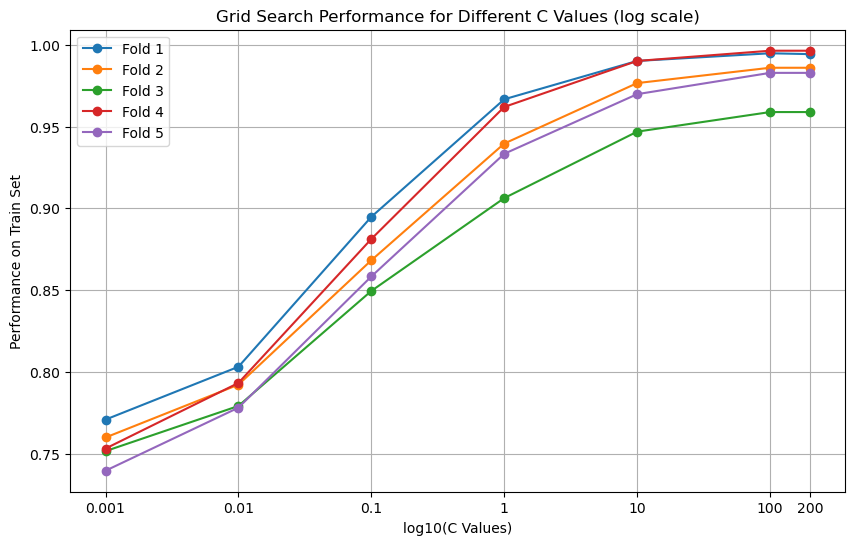

In [14]:
# Aggregate scores for each fold
aggregated_scores_train = {}
for i, scores in enumerate([split0_train_scores, split1_train_scores, split2_train_scores, split3_train_scores, split4_train_scores]):
    for j, score in enumerate(scores):
        C_value = params[j]['log_reg__C']
        if C_value not in aggregated_scores_train:
            aggregated_scores_train[C_value] = [score]
        else:
            aggregated_scores_train[C_value].append(score)

# Calculate mean scores for each C value
mean_scores_by_C_fold_train = {C: np.mean(aggregated_scores_train[C]) for C in aggregated_scores_train}

# Plotting
plt.figure(figsize=(10, 6))

# Plot mean performance of each fold
for i in range(5):
    fold_scores = [aggregated_scores_train[C][i] for C in hyperparams_C]
    plt.plot(np.log10(hyperparams_C), fold_scores, label=f'Fold {i+1}', marker='o')


# Add labels and legend
plt.xlabel('log10(C Values)')
plt.ylabel('Performance on Train Set')
plt.title('Grid Search Performance for Different C Values (log scale)')
plt.xticks(np.log10(hyperparams_C), hyperparams_C) 
plt.legend()
plt.grid(True)
plt.show()


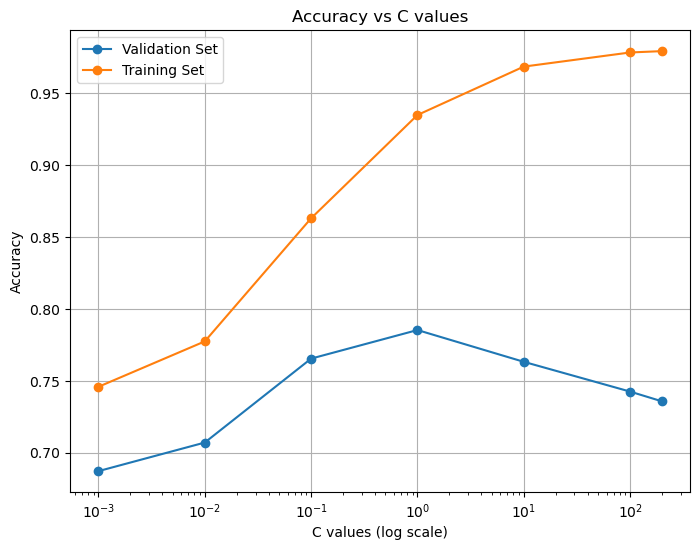

In [15]:
C_values = list(mean_scores_by_C_fold.keys())
accuracy_scores = list(mean_scores_by_C_fold.values())

C_values_train = list(mean_scores_by_C_fold_train.keys())
accuracy_scores_train = list(mean_scores_by_C_fold_train.values())

# Plot
plt.figure(figsize=(8, 6))
plt.plot(C_values, accuracy_scores, marker='o', linestyle='-', label='Validation Set')
plt.plot(C_values_train, accuracy_scores_train, marker='o', linestyle='-', label='Training Set')


# Set x-axis to log scale
plt.xscale('log')
plt.legend()

# Labels and title
plt.xlabel('C values (log scale)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C values')

# Show plot
plt.grid(True)
plt.show()

In [17]:
from sklearn.metrics import confusion_matrix

# Initialize lists to store false negatives and false positives
false_negatives = []
false_positives = []

simple_logistic = Pipeline([
    ('count', CountVectorizer(lowercase=True, stop_words='english', min_df=1)),
    ('log_reg', LogisticRegression(max_iter = 1200, C=1))
])

# Iterate over the first fold only
fold_idx = 0
train_index, val_index = next(stratified_kfold.split(X_train, y_train))
x_train_fold, x_val_fold = x_train_df_text.iloc[train_index], X_train.iloc[val_index]
y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

# Fit the model on the training data for the current fold
simple_logistic.fit(x_train_fold, y_train_fold)

# Obtain predictions for the validation set in the current fold
fold_predictions = simple_logistic.predict(x_val_fold)

# Obtain the confusion matrix
cm = confusion_matrix(y_val_fold, fold_predictions)
print(cm)

# Extract false negatives and false positives
false_negatives_indices = np.where((y_val_fold == 1) & (fold_predictions == 0))[0]
false_positives_indices = np.where((y_val_fold == 0) & (fold_predictions == 1))[0]

# Get the texts corresponding to false negatives and false positives
false_negatives_texts = x_val_fold.iloc[false_negatives_indices]
false_positives_texts = x_val_fold.iloc[false_positives_indices]

# Print false negatives
print("False Negatives (Fold 1):")
for idx, text in zip(false_negatives_indices, false_negatives_texts):
    print(f"Index: {idx}, Text: {text}")

# Print false positives
print("\nFalse Positives (Fold 1):")
for idx, text in zip(false_positives_indices, false_positives_texts):
    print(f"Index: {idx}, Text: {text}")


[[192  48]
 [ 56 184]]
False Negatives (Fold 1):
Index: 78, Text: amazon Worth every penny.
Index: 81, Text: amazon i'm glad i found this product on amazon it is hard to find, it wasn't high priced.
Index: 91, Text: amazon Virgin Wireless rocks and so does this cheap little phone!
Index: 98, Text: amazon its a little geeky but i think thats its sex on toast and it rocks and oozes sex right down to its battery embedded sleek stylish leather case.
Index: 100, Text: amazon I got it because it was so small and adorable.
Index: 106, Text: amazon I really like this product over the Motorola because it is allot clearer on the ear piece and the mic.
Index: 113, Text: amazon Small, sleek, impressive looking, practical setup with ample storage in place.
Index: 120, Text: amazon It worked very well.
Index: 124, Text: amazon clipping this to your belt will deffinitely make you feel like 50 cent's up-and-coming.
Index: 128, Text: amazon I did not have any problem with this item and would order it a